# 2D MRI Segmentation

In [1]:
# Libaries
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2025-01-06 18:33:02.032670: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Analysis and Visualization

In [2]:
# Load and preprocess data
data_U = loadmat('data/Brain.mat')
T1_U = data_U['T1']         # MRI slices
label_U = data_U['label']   # Corresponding labels

print("MRI Data Shape:", T1_U.shape)
print("Label Shape:", label_U.shape)

MRI Data Shape: (362, 434, 10)
Label Shape: (362, 434, 10)


In [3]:
print(data_U.keys())
print(T1_U[1:101, 1:101, 1])
print(label_U[1:101, 1:101, 1])

dict_keys(['__header__', '__version__', '__globals__', 'T1', 'label'])
[[  6787.634    6907.175    6907.175  ...  12645.159   13840.573
   13960.114 ]
 [  6429.01     6668.0923   7026.7163 ...  12525.618   13481.949
   14079.655 ]
 [  6548.551    6429.01     6668.0923 ...  15753.234   17426.812
   18861.309 ]
 ...
 [ 10852.039    9776.167    9058.919  ... 288546.6    285318.97
  279939.6   ]
 [ 10493.415    9895.709    9537.085  ... 291176.5    289263.8
  285318.97  ]
 [ 10015.25    10134.791    9895.709  ... 292371.9    291056.94
  288187.97  ]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]]


In [4]:
# Constants (TO BE ADDED TO CONFIG FILE)
NUM_CLASSES = 6
PATCH_SIZE = 64
BATCH_SIZE = 64
EPOCHS = 10

In [5]:
# Visualize an example slice and ground truth
def visualize_example(data, label, slice_idx):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("MRI Slice")
    plt.imshow(data[:, :, slice_idx], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Ground Truth")
    plt.imshow(label[:, :, slice_idx], cmap='jet')
    plt.axis('off')
    plt.show()

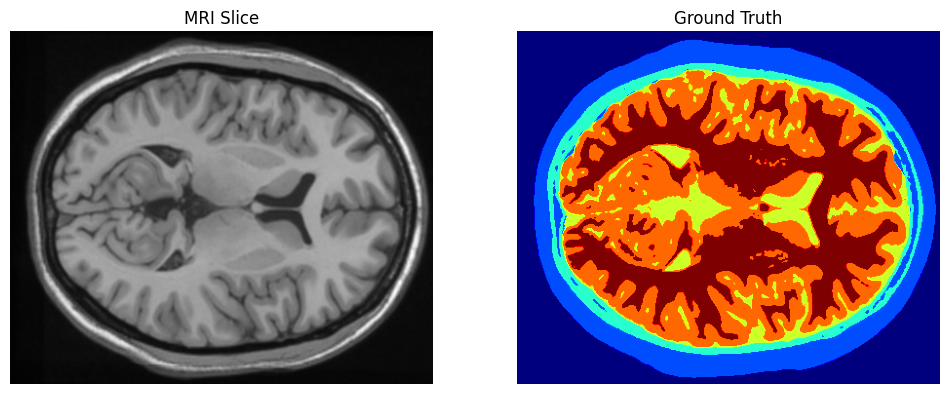

In [6]:
# Visualize slice 5 as an example
visualize_example(T1_U, label_U, slice_idx=5)

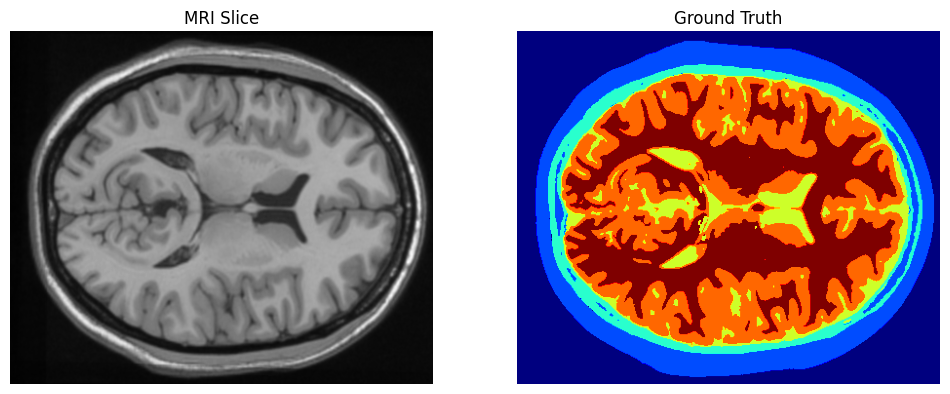

In [7]:
visualize_example(T1_U, label_U, slice_idx=9)

## Data Preprocessing

In [8]:
# Expand dimensions for channels (H, W, Slices) -> (H, W, 1, Slices)
T1 = np.expand_dims(T1_U, axis=-1)  # Shape: (362, 434, 10, 1)
label = np.expand_dims(label_U, axis=-1)  # Shape: (362, 434, 10, 1)

# Reshape data for splitting (S, H, W, C)
T1 = np.moveaxis(T1, -2, 0)  # Shape: (10, 362, 434, 1)
label = np.moveaxis(label, -2, 0)  # Shape: (10, 362, 434, 1)

# Split into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    T1, label, test_size=0.2, random_state=42
)

# Resize images and labels to (256, 256)
train_images = tf.image.resize(train_images, [256, 256])
test_images = tf.image.resize(test_images, [256, 256])
train_labels = tf.image.resize(train_labels, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
test_labels = tf.image.resize(test_labels, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

# Check shapes
print(train_images.shape, test_images.shape)  # Should be (8, 256, 256, 1) and (2, 256, 256, 1)
print(train_labels.shape, test_labels.shape)  # Same as above

(8, 256, 256, 1) (2, 256, 256, 1)
(8, 256, 256, 1) (2, 256, 256, 1)


## Metrics and 2D U-NET Architechture

**Metrics**: 
- Dice Coefficient
- IoU
- Jacardi Distance

In [9]:
# Dice Coefficient
def dice_coef(y_true, y_pred, smooth=10e-6):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return dice

def iou(y_true, y_pred, smooth=10e-6):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    sum_ = tf.keras.backend.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    return - iou(y_true, y_pred)


In [10]:
# 2D U-Net Architechture
def unet_2d(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(PATCH_SIZE, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(PATCH_SIZE, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(PATCH_SIZE*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(PATCH_SIZE*2, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(PATCH_SIZE*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(PATCH_SIZE*4, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(PATCH_SIZE*8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(PATCH_SIZE*8, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(PATCH_SIZE*16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(PATCH_SIZE*16, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(PATCH_SIZE*8, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(PATCH_SIZE*8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(PATCH_SIZE*8, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(PATCH_SIZE*4, (2, 2),strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(PATCH_SIZE*4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(PATCH_SIZE*4, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(PATCH_SIZE*2, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(PATCH_SIZE*2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(PATCH_SIZE*2, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(PATCH_SIZE, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(PATCH_SIZE, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(PATCH_SIZE, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [11]:
# Compile Test Model
model = unet_2d()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │       0 │ -                    │
│ (InputLayer)        │ 1)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │     640 │ input_layer[0][0]    │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │  36,928 │ conv2d[0][0]         │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │       0 │ conv2d_1[0][0]       │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │  73,856 │ max_pooling2d[0][0]  │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │ 147,584 │ conv2d_2[0][0]       │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │       0 │ conv2d_3[0][0]       │
│ (MaxPooling2D)      │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │ 295,168 │ max_pooling2d_1[0][… │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │ 590,080 │ conv2d_4[0][0]       │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │       0 │ conv2d_5[0][0]       │
│ (MaxPooling2D)      │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │ 1,180,… │ max_pooling2d_2[0][… │
│                     │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │ 2,359,… │ conv2d_6[0][0]       │
│                     │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │       0 │ conv2d_7[0][0]       │
│ (MaxPooling2D)      │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │ 4,719,… │ max_pooling2d_3[0][… │
│                     │ 1024)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │ 9,438,… │ conv2d_8[0][0]       │
│                     │ 1024)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │ 2,097,… │ conv2d_9[0][0]       │
│ (Conv2DTranspose)   │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, 32, 32,    │       0 │ conv2d_transpose[0]

 Total params: 31,030,918 (118.37 MB)

 Trainable params: 31,030,918 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

## Training 

**Loss**: categorical cross entropy
**Metric**: accuracy (TODO: use dice coefficient)

In [12]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_images, train_labels, 
    batch_size=2, epochs=20, 
    validation_data=(test_images, test_labels)
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 76s 15s/step - accuracy: 0.1644 - loss: 11310.1172 - val_accuracy: 0.2173 - val_loss: 1307.8833
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step - accuracy: 0.2290 - loss: 1243.6741 - val_accuracy: 0.2684 - val_loss: 639.2819
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step - accuracy: 0.2754 - loss: 604.8044 - val_accuracy: 0.2042 - val_loss: 378.8790
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step - accuracy: 0.2558 - loss: 337.8403 - val_accuracy: 0.3108 - val_loss: 231.4520
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.3084 - loss: 199.2254 - val_accuracy: 0.3205 - val_loss: 136.3878
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.3204 - loss: 131.2131 - val_accuracy: 0.3178 - val_loss: 85.3468
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.3296 - loss: 85.5458 - val_accuracy: 0.4166 - val_loss: 60.3697
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 335s 109s/step - accuracy: 0.3923 - loss: 61.1783 - val_accuracy

In [13]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6009 - loss: 14.9996
Test Loss: 14.999626159667969, Test Accuracy: 0.6009140014648438


## Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


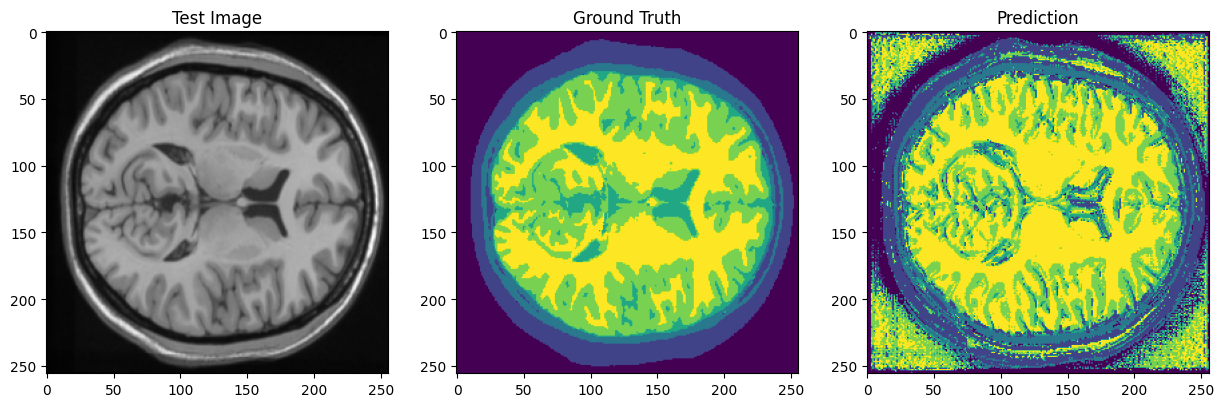

In [14]:
predictions = model.predict(test_images)

test_index = 0
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Test Image")
plt.imshow(test_images[test_index, :, :, 0], cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(test_labels[test_index, :, :, 0], cmap='viridis')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(np.argmax(predictions[test_index], axis=-1), cmap='viridis')